# Passage Retrieval - Scaling Up

## 1. Passage Retrieval and Similarity Search

* MIPS(Maximum Inner Product Search)
  * 주어진 질문(query) 벡터 q에 대해 passage 벡터 v들 중 가장 질문과 관련된 벡터를 찾아야 함
    * 관련성 : 내적(inner product)이 가장 큰 것
  * scalar score 중 가장 높은 score를 가진 i번째 vector를 찾음
  * 기존에 사용하던 brute-force(exhaustive) search는 모든 vector들을 하나씩 go over하면서 연산을 하고 가장 높은 값을 찾는 방식으로 개수가 많아질수록 비효율적임 

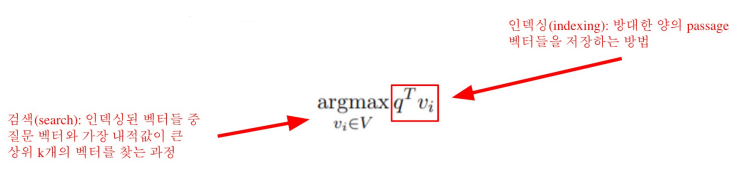

* MIPS in Passage Retrieval
  * encoding이후 검색하는 과정

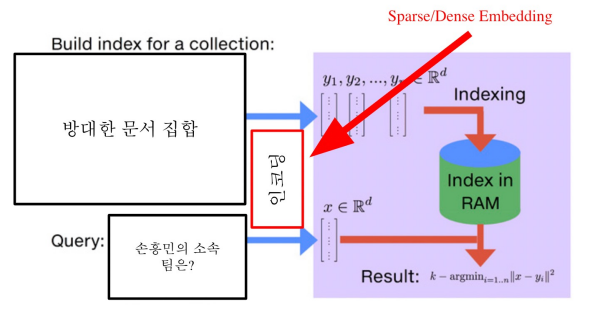

* MIPS & Challenges
  * 실제로 검색해야할 데이터는 훨씬 방대함
    * 5백만 개(위키피디아)
    * 문서단위가 아닌 passage 또는 paragraph 단위로 볼 수 있기 때문에 수십 억, 조 단위까지 커질 수 있음
  <br> => 따라서 더이상 모든 문서 임베딩을 일일히 보면서 검색할 수 없음

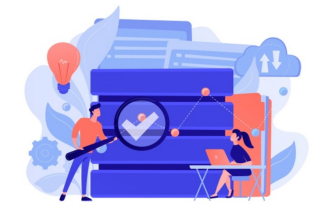

* Tradeoffs of similarity search
  * 짧은 시간 내에 가장 가까운 문서를 찾기 위해 tradeoff를 고려해야 함
  1. Search Speed
    * 쿼리 당 유사한 벡터를 k 개 찾는데 얼마나 걸리는지?
    <br> => 가지고 있는 벡터량이 클수록 더 오래걸림
  2. Memory Usage
    * 벡터를 사용할 때, 어디에서 가져올 것인지?
    <br> => RAM에 모두 올려둘 수 있으면 빠르지만, 많은 RAM 용량을 요구함
    <br> => 디스크에서 계속 불러와야한다면 속도가 느려짐
  3. Accuracy
    * brute-force 검색 결과와 얼마나 비슷한지?
    <br> => 속도를 증가시키려면 정확도를 희생해야하는 경우가 많음

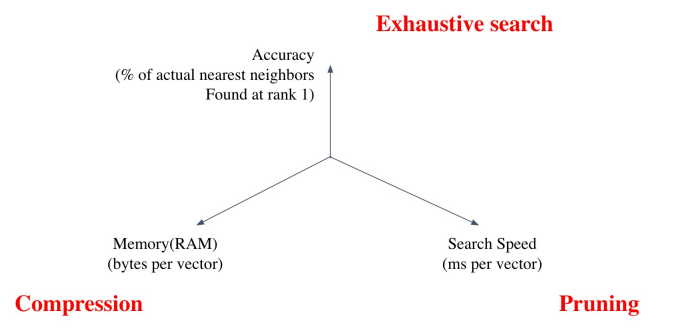

* Tradeoff of search speed and accuracy
  * 속도(search time)와 재현율(recall)의 관계
    * 더 정확한 검색을 하려면 더 오랜 시간이 소모됨

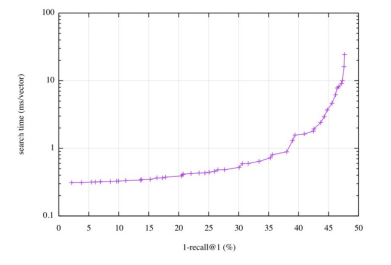

* Increasing search space by bigger corpus
  * 코퍼스(corpus)의 크기가 커질수록
    * 탐색 공간이 커지고 검색이 어려워짐
    * 저장해 둘 Memory space 또한 많이 요구됨
    * Sparse Embedding의 경우 이러한 문제가 훨씬 심함

* ex. 1M docs, 500K distinct terms = 2TB

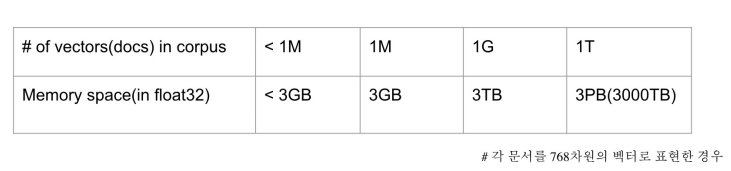

## 2. Approximating Similarity Search

* 속도 측면에서 문제를 해결하기 위한 approximation 활용 방법

* Compression - Scalar Quantization (SQ)
  * 숫자를 compression 하는 방법론
  * 실제 inner product search를 할 때, 4byte까지 필요한 경우가 거의 없음. 1byte로 approximate한 다음 저장해도 상당히 정확한 경우가 많음
  * Compression : vector를 압축하여, 하나의 vector가 적은 용량을 차지 => 압축량 $\uparrow$ => 메모리 $\downarrow$, 정보 손실 $\uparrow$
  * quantization : 수치를 quantize한 후 quantize한 값에 대해 용량을 줄임(압축하는 알고리즘)
    * 기본적으로 float32 4byte에서 4배 압축 가능함

* ex. Scalar quantization: 4-byte floating point => 1-byte (8bit) unsigned integer로 압축

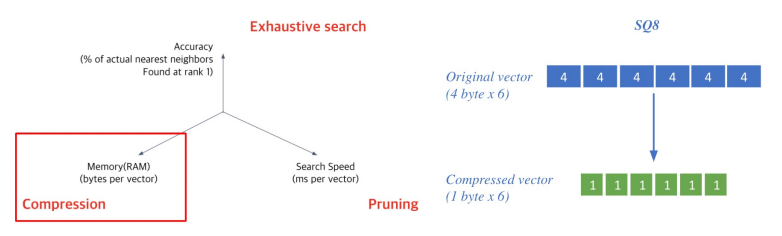

* Pruning - Inverted File (IVF)
  * 점들을 정해진 cluster로 소속시켜서 군집을 일으키는 형태
  * 군집이 이루어진 상태에서 query가 들어온 경우, query에 가장 근접한 cluster만 보는 방식
    * cluster 내에 있는 point에 대해 exhaustive search로 직접 비교함
    * ex. data point가 100만개, cluster가 1000개, 각 query의 time마다 10개의 cluster만 visit하는 경우, 원래 1000개의 cluster를 모두 방문에 100만개의 point를 봐야 했다면 100분의 1인 10개만 보면 됨. 속도가 100분의 1로 줄어듬(빨라짐) 
  * clustering이 잘 된 경우 멀리 있는 cluster는 아예 볼 필요 없음
    * cluster 내에 있는 점들이 아무리 가까워도, top-k안에 들지 않기 때문
  * Pruning: Search space 를 줄여 search 속도 개선 (dataset의 subset만 방문)
  <br> => Clustering + Inverted file을 활용한 search
  1. Clustering: 전체 vector space를 k 개의 cluster로 나눔 (ex.k-means clustering : 가장 자주 활용되는 방법론)
    * k-means clustering을 통해 cluster를 정의
    * 각 document vector들을 가장 가까운 cluster에 속하게 함
    * 군집이 형성되면 query time 때 가장 가까운 cluster만 순차적으로 방문하여 속도를 비약적으로 늘림

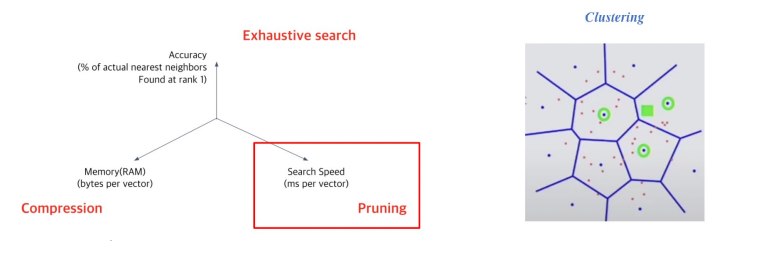

* Pruning - Inverted File (IVF)
  2. Inverted file (IVF)
    * Vector의 index = inverted list structure
    <br> => (각 cluster의 centroid id)와 (해당 cluster의 vector들)이 연결되어있는 형태
      * 각 cluster에 속해있는 point들을 index로 가지고 있음

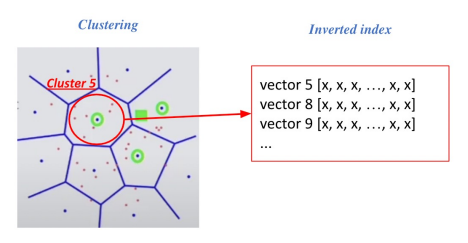

* Pruning - Inverted File (IVF)
  * Searching with clustering and IVF
    1. 주어진 query vector에 대해 근접한 centroid 벡터를 찾음
    2. 찾은 cluster의 inverted list 내 vector들에 대해 서치 수행
    * cluster를 찾은 다음 cluster에 속해있는 vector들을 빠르게 확보함으로써 search space를 비약적으로 빠른 시간 내에 줄일 수 있음

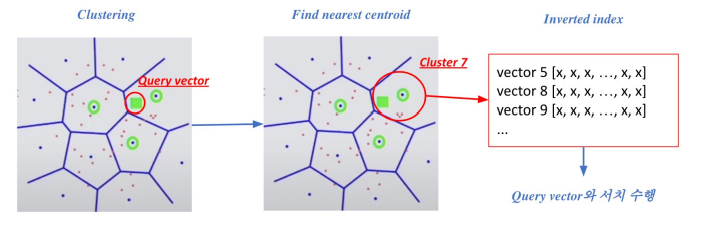

## 3. Introductio to FAISS

* What is FAISS
  * facebook에서 만든 faiss approximation을 위한 library 
  * large scale에 상당히 특화되어있어서 scale up할 때 상당히 용이하게 활용할 수 있음
  * FAISS github : https://github.com/facebookresearch/faiss
  * FAISS tutorial : https://github.com/facebookresearch/faiss/tree/master/tutorial/python

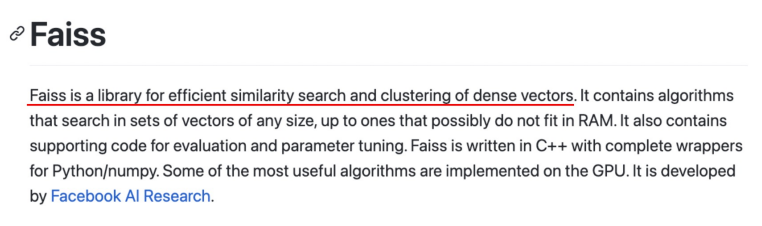

* What is FAISS
  * FAISS : Library for efficient similarity search
  * indexing 쪽을 도와줌

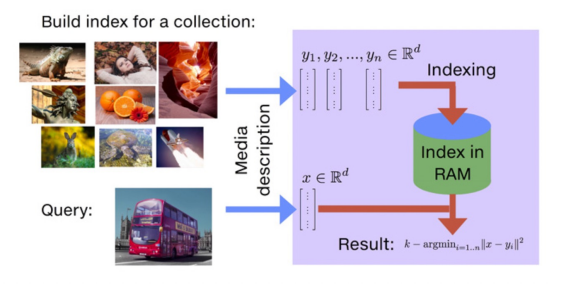

* Passage Retrieval with FAISS
  1. Train index and map vectors
    * vectors를 확보하면 먼저 학습함
      * faiss를 활용하려면 cluster들을 확보해야함(pruning)
      * random하게 cluster를 지정하면 비효율적이기 때문에 data point들의 분포를 보고 적절하게 cluster를 지정해야함
      * cluster를 지정하기 위해 학습 data가 필요함
      * scalar quantize하는 과정에서(float32를 integer로 변환) 아주 range가 큰 number를 integer 0부터 255사이로 압축시키는 것을 볼 수 있음
        * float number의 max와 min가 얼마인지, 얼마만큼 scale하고, offset을 할 것인지에 대해 파악할 필요가 있기 때문에 faiss index를 building할 때 학습단계가 필요함
        * 학습 단계에서 cluster와 scalar quntization하는 비율과 offset을 계산함
    * 학습데이터를 통해서 cluster와 SQ8이 정의 되면 cluster와 cluster 내의 vector들을 SQ8 형태(quantize된 형태)로 투입함
    * 많은 경우 학습 데이터와 더하는 데이터를 다르게 하지 않음
      * 다르게 하는 경우 : 더할 데이터가 많아서 전부를 학습하기에 비효율적일 때 add할 데이터의 일부를 sample해서 학습 데이터로 활용함
      * 데이터가 정말 큰 경우 40분의 1로 sample해서 사용하기도 함

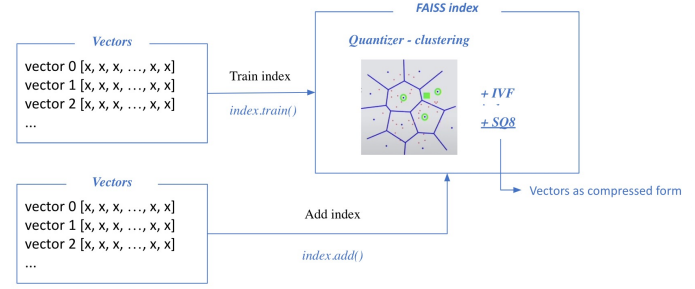

* Passage Retrieval with FAISS
  2. Search based of FAISS index
    * nprobe : 몇 개의 가장 가까운 cluster를 방문하여 search할 것인지

    * faiss index가 만들어지면 inference time 때 query가 들어오게 되고, 검색한 후 가장 가까운 cluster들을 방문하여 cluster 내의 vector들을 일일이 비교함으로써 top-k 개의 가장 가까운 문서 vector(faiss는 문서가 아닌 일반적인 vector도 가능함)들을 뽑아줌

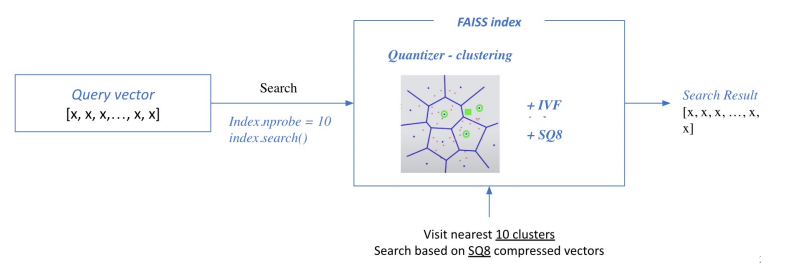

## 4. Scaling up with FAISS

* FAISS Basics
  * brute-force로 모든 벡터와 쿼리를 비교하는 가장 단순한 인덱스 만들기
    * `faiss.IndexFlatL2(d)` : dimension 정의
    * pruning과 SQ를 하지 않기 때문에 학습이 필요 없음
    * `index.search(xq, k)`
      * `k` : top-k
      * `xq` : query


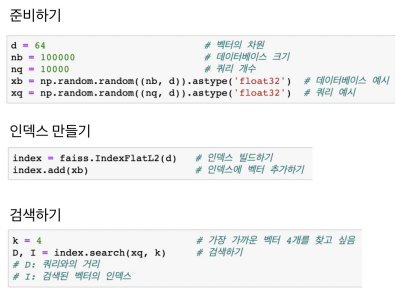

* IVF with FAISS
  * IVF 인덱스 만들기
  * clustering을 통해서 가까운 cluster 내 vector들만 비교함
  * 빠른 검색 가능함
  * cluster 내에서는 여전히 전체 벡터와 거리를 비교함 (flat)

  * `faiss.IndexIVVFlat(quantizer, d, nlist)` : quantizer를 활용하여 cluster들을 생성
    * `nlist` : cluster 개수
  * `index.train(xb)`
    * train과정 중에 IndexIVFFlat이 학습 데이터 xb를 활용하여 nlist 개수만큼 cluster를 k-means algorithm으로 생성함
  * `index.add(xb)`
    * `xb`가 너무 큰 경우 학습할 때 오래걸릴 수 있기 때문에 `xb`를 일부 sample에서 학습한 후 더함(retrieval에서 임의로 대상을 뺄 수 없기 때문에 전부 더함)
  * `index.search(xq, k)`
    * query가 들어왔을 때 search함    
    * 가장 가까운 몇 개의 cluster만 방문하여 답을 내어옴


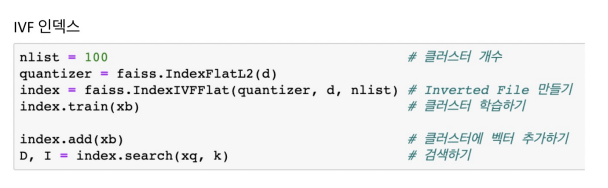

* IVF-PQ with FAISS
  * 벡터 압축 기법 (PQ) 활용하기
    * SQ가 압축량을 조금 더 늘릴 수 있음
    * SQ와 마찬가지로 학습이 필요하고, 학습을 하는 방법론이 비슷함
    * SQ보다 훨씬 더 줄일 수 있음. SQ : 4byte->1byte, PQ : 경우에 따라 768 dimension vector의 size가 768X4인 경우 100byte로 줄일 수 있음
    * SQ를 사용한 후 PQ로 넘어가는 것을 추천함
  * 전체 벡터를 저장하지 않고 압축된 벡터만을 저장함
  * 메모리 사용량을 줄일 수 있음

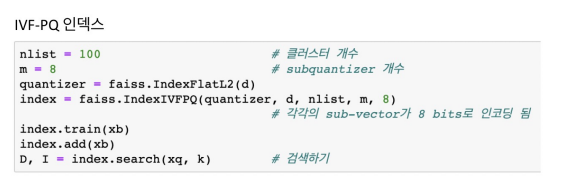

* Using GPU with FAISS
  * GPU의 빠른 연산 속도를 활용할 수 있음
    * 거리 계산을 위한 행렬곱 등에서 유리함
  * 다만, GPU 메모리 제한(vector 개수 제한됨)이나 메모리 random access 시간이 느린 것 등이 단점
  * GPU에서 활용할 수 있는 library 가 한정적임

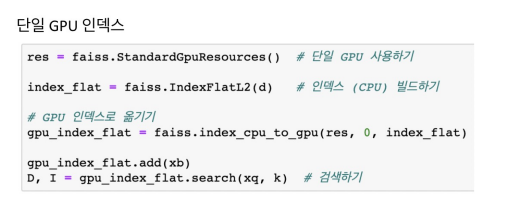

* Using Multiple GPUs with FAISS
  * 여러 GPU를 활용하여 연산 속도를 한층 더 높일 수 있음
  * 단일 GPU 사용 후 multiple GPU로 넘어가는 것을 추천함
    * 대부분 multi GPU까지 활용할 필요 없음

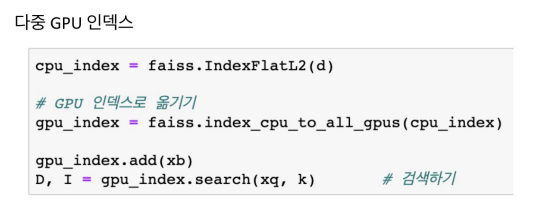